In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action='ignore')

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "1"  # Set the GPU number to use

# Preparation

In [2]:
def img_dir_load(dir_path):
    result = []
    for folder in os.listdir(dir_path):
        img_path = os.path.join(dir_path, folder)
        for file in tqdm( os.listdir(img_path) ):
            img = image.load_img( os.path.join(img_path, file), target_size=(128, 128))
            img_tensor = image.img_to_array(img)
            # scaling into [0, 1]
            img_tensor /= 255.
            result.append(img_tensor)
    
    return np.array(result)

def mk_labe(dir_path):
    result = np.array([])
    for folder in os.listdir(dir_path):
        img_path = os.path.join(dir_path, folder)
        len_file = len( os.listdir(img_path) )
        result = np.append( result, np.array([folder]*len_file) )
    
    return result

In [3]:
img_path = "/home/pkwmay/202103_Hallym_leenuri/dataset/03_classification/211209_labelled_cls_1000/"

img = img_dir_load(img_path)
label = mk_labe(img_path)

encoder = LabelEncoder()
encoder.fit(label)
enc_label = encoder.transform(label)

100%|██████████| 24/24 [00:00<00:00, 283.68it/s]


In [4]:
x_train, x_test, y_train, y_test = train_test_split(img, enc_label, test_size=0.1, random_state=777)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6868, 128, 128, 3)
(764, 128, 128, 3)
(6868,)
(764,)


# Modeling & Run

In [35]:
#option
lr = 1e-5
batch = 128
epoch = 30

## VGG16

In [36]:
vgg16 = VGG16(weights=None, input_shape=x_train.shape[1:], include_top=False)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [37]:
v_model = Sequential()
v_model.add(vgg16)
v_model.add(GlobalAveragePooling2D())
v_model.add(Dropout(0.5))
v_model.add(Dense(8, activation='softmax'))
v_model.summary()
v_model.compile(optimizer = Adam(lr), loss='sparse_categorical_crossentropy', metrics='acc')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 14,718,792
Trainable params: 14,718,792
Non-trainable params: 0
_________________________________________________________________


In [38]:
v_history = v_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epoch, batch_size=batch)

Epoch 1/30


2022-03-04 10:37:21.828812: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-04 10:37:21.828876: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2022-03-04 10:37:21.975772: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-03-04 10:37:21.975829: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_4/vgg16/block1_conv2/Conv2D' defined at (most recent call last):
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_19296/2078740393.py", line 1, in <module>
      v_history = v_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epoch, batch_size=batch)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/pkwmay/anaconda3/envs/py38_tf/lib/python3.8/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_4/vgg16/block1_conv2/Conv2D'
OOM when allocating tensor with shape[128,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_4/vgg16/block1_conv2/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_521922]

In [ ]:
v_pred = v_model.predict(x_test)

In [ ]:
print('###prediction###')
print( np.argmax(v_pred[:10], axis=1) )
print('###label###')
print(y_test[:10])

###prediction###
[3 4 3 4 2 1 2 2 1 4]
###label###
[3 4 4 4 2 4 2 2 1 3]


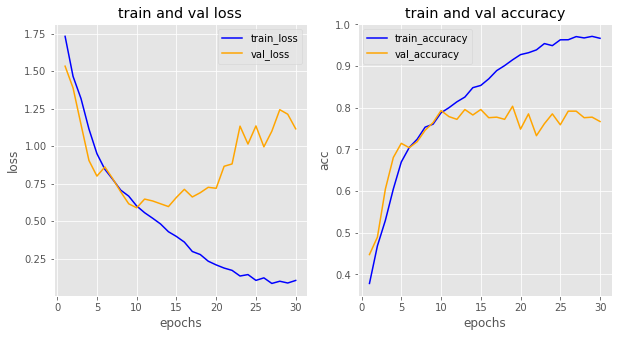

In [ ]:
his_dict = v_history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']
epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

train_iou = his_dict['acc']
val_iou = his_dict['val_acc']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, train_iou, color = 'blue', label = 'train_accuracy')
ax2.plot(epochs, val_iou, color = 'orange', label = 'val_accuracy')
ax2.set_title('train and val accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

## InceptionV3

In [ ]:
inception = inception_v3.InceptionV3(weights=None, input_shape=x_train.shape[1:], include_top=False)
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [ ]:
i_model = Sequential()
i_model.add(inception)
i_model.add(GlobalAveragePooling2D())
i_model.add(Dropout(0.5))
i_model.add(Dense(8, activation='softmax'))
i_model.summary()
i_model.compile(optimizer = Adam(lr), loss='sparse_categorical_crossentropy', metrics='acc')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 21,819,176
Trainable params: 21,784,744
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
i_history = i_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epoch, batch_size=batch)

Epoch 1/30
859/859 [==============================] - 63s 65ms/step - loss: 1.5076 - acc: 0.4932 - val_loss: 1.8104 - val_acc: 0.5484
Epoch 2/30
859/859 [==============================] - 52s 60ms/step - loss: 1.2512 - acc: 0.5676 - val_loss: 1.1204 - val_acc: 0.6361
Epoch 3/30
859/859 [==============================] - 54s 63ms/step - loss: 1.1215 - acc: 0.6115 - val_loss: 0.9308 - val_acc: 0.6767
Epoch 4/30
859/859 [==============================] - 54s 63ms/step - loss: 1.0393 - acc: 0.6377 - val_loss: 1.0606 - val_acc: 0.6584
Epoch 5/30
859/859 [==============================] - 54s 62ms/step - loss: 0.9671 - acc: 0.6529 - val_loss: 0.8412 - val_acc: 0.7068
Epoch 6/30
859/859 [==============================] - 53s 62ms/step - loss: 0.9037 - acc: 0.6821 - val_loss: 0.7745 - val_acc: 0.7317
Epoch 7/30
859/859 [==============================] - 53s 61ms/step - loss: 0.8580 - acc: 0.6902 - val_loss: 0.8682 - val_acc: 0.7094
Epoch 8/30
859/859 [==============================] - 52s 61ms

In [ ]:
i_pred = i_model.predict(x_test)

In [ ]:
print('###prediction###')
print( np.argmax(i_pred[:10], axis=1) )
print('###label###')
print(y_test[:10])

###prediction###
[3 4 7 4 4 4 2 1 3 4]
###label###
[3 4 4 4 2 4 2 2 1 3]


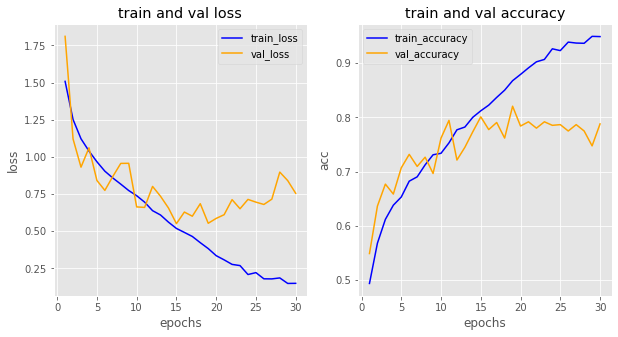

In [ ]:
his_dict = i_history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']
epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

train_iou = his_dict['acc']
val_iou = his_dict['val_acc']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, train_iou, color = 'blue', label = 'train_accuracy')
ax2.plot(epochs, val_iou, color = 'orange', label = 'val_accuracy')
ax2.set_title('train and val accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

## Xception

In [ ]:
xception = Xception(weights=None, input_shape=x_train.shape[1:], include_top=False)
xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 63, 63, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 63, 63, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [ ]:
x_model = Sequential()
x_model.add(xception)
x_model.add(GlobalAveragePooling2D())
x_model.add(Dropout(0.5))
x_model.add(Dense(8, activation='softmax'))
x_model.compile(optimizer = Adam(lr), loss='sparse_categorical_crossentropy', metrics='acc')

In [ ]:
x_history = x_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epoch, batch_size=batch)

Epoch 1/30
859/859 [==============================] - 49s 53ms/step - loss: 1.0508 - acc: 0.6211 - val_loss: 1.0331 - val_acc: 0.6270
Epoch 2/30
859/859 [==============================] - 44s 51ms/step - loss: 0.7341 - acc: 0.7369 - val_loss: 0.6386 - val_acc: 0.7736
Epoch 3/30
859/859 [==============================] - 44s 51ms/step - loss: 0.5660 - acc: 0.7978 - val_loss: 0.7493 - val_acc: 0.7395
Epoch 4/30
859/859 [==============================] - 43s 50ms/step - loss: 0.4261 - acc: 0.8444 - val_loss: 0.8228 - val_acc: 0.7238
Epoch 5/30
859/859 [==============================] - 44s 52ms/step - loss: 0.3208 - acc: 0.8819 - val_loss: 0.8098 - val_acc: 0.7487
Epoch 6/30
859/859 [==============================] - 44s 51ms/step - loss: 0.2252 - acc: 0.9209 - val_loss: 0.6749 - val_acc: 0.7762
Epoch 7/30
859/859 [==============================] - 45s 52ms/step - loss: 0.1854 - acc: 0.9348 - val_loss: 0.7971 - val_acc: 0.7801
Epoch 8/30
859/859 [==============================] - 45s 52ms

In [ ]:
x_pred = x_model.predict(x_test)

In [ ]:
print('###prediction###')
print( np.argmax(x_pred[:10], axis=1) )
print('###label###')
print(y_test[:10])

###prediction###
[3 4 3 4 2 4 2 3 3 3]
###label###
[3 4 4 4 2 4 2 2 1 3]


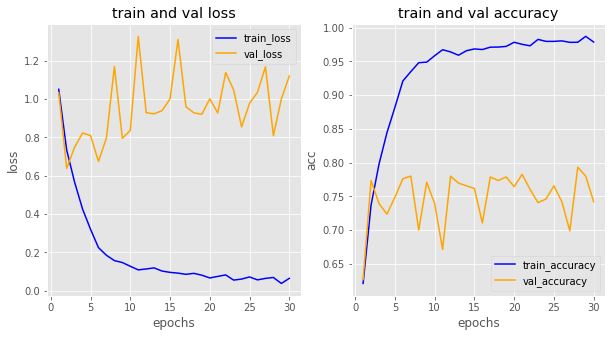

In [ ]:
his_dict = x_history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']
epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

train_iou = his_dict['acc']
val_iou = his_dict['val_acc']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, train_iou, color = 'blue', label = 'train_accuracy')
ax2.plot(epochs, val_iou, color = 'orange', label = 'val_accuracy')
ax2.set_title('train and val accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

## Efficient net

In [ ]:
def img_dir_load(dir_path):
    result = []
    for folder in os.listdir(dir_path):
        img_path = os.path.join(dir_path, folder)
        for file in tqdm( os.listdir(img_path) ):
            img = image.load_img( os.path.join(img_path, file), target_size=(260, 260))
            img_tensor = image.img_to_array(img)
            # scaling into [0, 1]
            img_tensor /= 255.
            result.append(img_tensor)
    
    return np.array(result)

def mk_labe(dir_path):
    result = np.array([])
    for folder in os.listdir(dir_path):
        img_path = os.path.join(dir_path, folder)
        len_file = len( os.listdir(img_path) )
        result = np.append( result, np.array([folder]*len_file) )
    
    return result

In [ ]:
img_path = "/home/pkwmay/202103_Hallym_leenuri/dataset/03_classification/211209_labelled_cls_1000/"

img = img_dir_load(img_path)
label = mk_labe(img_path)

encoder = LabelEncoder()
encoder.fit(label)
enc_label = encoder.transform(label)

100%|██████████| 24/24 [00:00<00:00, 274.18it/s]


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img, enc_label, test_size=0.1, random_state=777)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6868, 224, 224, 3)
(764, 224, 224, 3)
(6868,)
(764,)


In [ ]:
efficient = EfficientNetB2(weights=None, input_shape=x_train.shape[1:], include_top=False)
efficient.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [ ]:
e_model = Sequential()
e_model.add(efficient)
e_model.add(GlobalAveragePooling2D())
e_model.add(Dropout(0.5))
e_model.add(Dense(8, activation='softmax'))
e_model.compile(optimizer = Adam(lr), loss='sparse_categorical_crossentropy', metrics='acc')

In [ ]:
e_history = e_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epoch, batch_size=batch)

Epoch 1/30
859/859 [==============================] - 75s 79ms/step - loss: 1.5580 - acc: 0.4521 - val_loss: 1.4430 - val_acc: 0.4791
Epoch 2/30
859/859 [==============================] - 65s 76ms/step - loss: 1.2618 - acc: 0.5499 - val_loss: 1.1175 - val_acc: 0.6178
Epoch 3/30
859/859 [==============================] - 66s 77ms/step - loss: 1.0614 - acc: 0.6117 - val_loss: 0.9587 - val_acc: 0.6741
Epoch 4/30
859/859 [==============================] - 66s 76ms/step - loss: 0.9470 - acc: 0.6551 - val_loss: 0.8150 - val_acc: 0.7330
Epoch 5/30
859/859 [==============================] - 66s 77ms/step - loss: 0.8626 - acc: 0.6859 - val_loss: 1.2068 - val_acc: 0.6257
Epoch 6/30
859/859 [==============================] - 66s 77ms/step - loss: 0.7796 - acc: 0.7220 - val_loss: 0.7798 - val_acc: 0.7343
Epoch 7/30
859/859 [==============================] - 66s 77ms/step - loss: 0.6985 - acc: 0.7462 - val_loss: 0.6767 - val_acc: 0.7631
Epoch 8/30
859/859 [==============================] - 66s 76ms

In [ ]:
e_pred = e_model.predict(x_test)

In [ ]:
print('###prediction###')
print( np.argmax(e_pred[:10], axis=1) )
print('###label###')
print(y_test[:10])

###prediction###
[4 4 3 4 1 4 2 2 4 4]
###label###
[3 4 4 4 2 4 2 2 1 3]


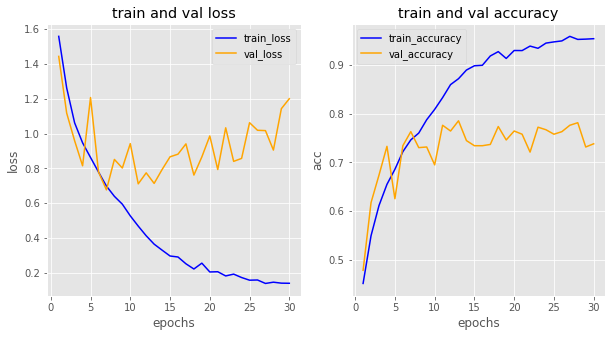

In [ ]:
his_dict = e_history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']
epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

train_iou = his_dict['acc']
val_iou = his_dict['val_acc']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, train_iou, color = 'blue', label = 'train_accuracy')
ax2.plot(epochs, val_iou, color = 'orange', label = 'val_accuracy')
ax2.set_title('train and val accuracy')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

## History save

In [ ]:
import datetime
import pandas as pd
now = datetime.datetime.now()
now = now.strftime('%y%m%d_%H%M%S')

result = pd.DataFrame(v_history.history)
result.to_csv('hist/vgg16_history_{}.csv'.format(now))
result = pd.DataFrame(i_history.history)
result.to_csv('hist/inception_history_{}.csv'.format(now))
result = pd.DataFrame(x_history.history)
result.to_csv('hist/Xception_history_{}.csv'.format(now))
result = pd.DataFrame(e_history.history)
result.to_csv('hist/Efficient_history_{}.csv'.format(now))